In [7]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

base_path = '/content/drive/MyDrive/COMP9517_ZXCZH'
train_dir = os.path.join(base_path, 'train')
test_dir = os.path.join(base_path, 'test')


In [9]:
# Data Augmentation
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Data Loading
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

class_names = train_dataset.classes
print("Classes:", class_names)


Classes: ['Agriculture', 'Airport', 'Beach', 'City', 'Desert', 'Forest', 'Grassland', 'Highway', 'Lake', 'Mountain', 'Parking', 'Port', 'Railway', 'Residential', 'River']


In [10]:
# Load the ResNet18 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights='IMAGENET1K_V1')
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(class_names))
model = model.to(device)


In [11]:
def train_model(model, train_loader, test_loader, epochs=10, lr=0.001):
    # Define the loss function: CrossEntropyLoss for multi-class classification
    criterion = nn.CrossEntropyLoss()
    # Define the optimizer: Adam with specified learning rate
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Store average training loss per epoch for visualization later
    train_losses = []

    # Training loop over the specified number of epochs
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0  # Accumulate loss for the current epoch
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")  # Progress bar for training batches

        for images, labels in loop:
            # Move images and labels to the appropriate device (CPU or GPU)
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass (compute gradients)
            optimizer.step()  # Update model weights

            running_loss += loss.item()  # Accumulate loss
            loop.set_postfix(loss=loss.item())  # Show current loss on the progress bar

        # Compute average loss for the epoch and store it
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")

    # Return list of average training losses per epoch
    return train_losses


In [12]:
# Train
train_losses = train_model(model, train_loader, test_loader, epochs=10, lr=0.0005)
# evaluate(model, test_loader, class_names)


Epoch 1/10: 100%|██████████| 75/75 [05:48<00:00,  4.64s/it, loss=0.301]


Epoch 1 Loss: 0.4382


Epoch 2/10: 100%|██████████| 75/75 [01:30<00:00,  1.21s/it, loss=0.284]


Epoch 2 Loss: 0.2085


Epoch 3/10: 100%|██████████| 75/75 [01:28<00:00,  1.19s/it, loss=0.183]


Epoch 3 Loss: 0.1517


Epoch 4/10: 100%|██████████| 75/75 [01:29<00:00,  1.19s/it, loss=0.0616]


Epoch 4 Loss: 0.1299


Epoch 5/10: 100%|██████████| 75/75 [01:31<00:00,  1.21s/it, loss=0.107]


Epoch 5 Loss: 0.1097


Epoch 6/10: 100%|██████████| 75/75 [01:29<00:00,  1.20s/it, loss=0.0566]


Epoch 6 Loss: 0.1074


Epoch 7/10: 100%|██████████| 75/75 [01:30<00:00,  1.21s/it, loss=0.137]


Epoch 7 Loss: 0.0939


Epoch 8/10: 100%|██████████| 75/75 [01:26<00:00,  1.15s/it, loss=0.103]


Epoch 8 Loss: 0.0780


Epoch 9/10: 100%|██████████| 75/75 [01:26<00:00,  1.15s/it, loss=0.118]


Epoch 9 Loss: 0.0826


Epoch 10/10: 100%|██████████| 75/75 [01:28<00:00,  1.18s/it, loss=0.0471]

Epoch 10 Loss: 0.0740


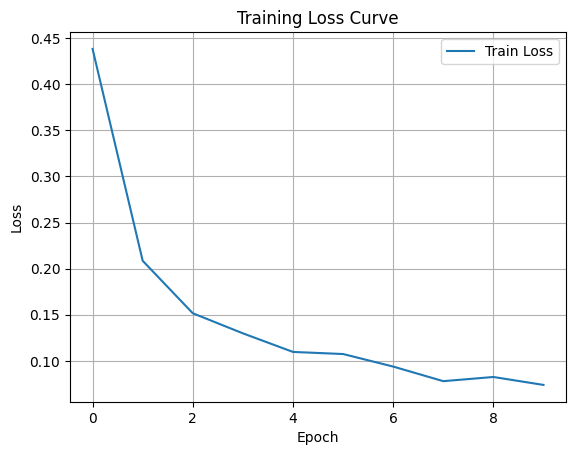

In [13]:
# Visualize Training Loss
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()



ResNet Final Evaluation on Test Set:
ResNet Test dataset Accuracy: 93.88%
ResNet Test dataset Precision: 94.22%
ResNet Test dataset Recall: 93.88%
ResNet Test dataset F1-score: 93.91%

ResNet Final classification report:
              precision    recall  f1-score   support

 Agriculture       0.94      0.98      0.96       160
     Airport       0.82      0.94      0.87       160
       Beach       0.97      0.94      0.96       160
        City       0.94      0.92      0.93       160
      Desert       0.97      0.93      0.95       160
      Forest       0.99      0.97      0.98       160
   Grassland       0.95      0.97      0.96       160
     Highway       0.97      0.88      0.92       160
        Lake       0.89      0.97      0.93       160
    Mountain       0.92      0.97      0.94       160
     Parking       1.00      0.94      0.97       160
        Port       0.99      0.97      0.98       160
     Railway       0.85      0.97      0.91       160
 Residential       0.

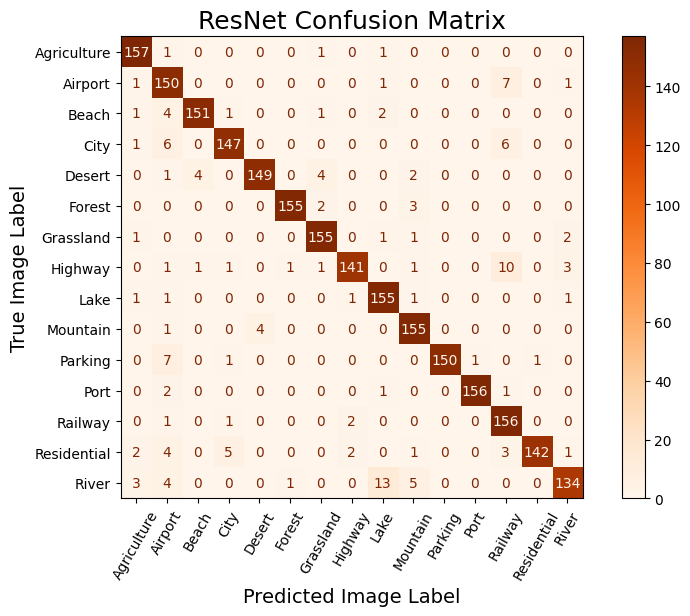

In [14]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
# ______________________ResNet Final Evaluation_________________________________
print("\nResNet Final Evaluation on Test Set:")
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Use accuracy, precision, recall and f1 as the evaluation metrics.
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"ResNet Test dataset Accuracy: {accuracy * 100:.2f}%")
print(f"ResNet Test dataset Precision: {precision * 100:.2f}%")
print(f"ResNet Test dataset Recall: {recall * 100:.2f}%")
print(f"ResNet Test dataset F1-score: {f1 * 100:.2f}%")

# ResNet Classification report.
print("\nResNet Final classification report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# ResNet Confusion matrix:
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(10, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
disp.plot(cmap='Oranges', xticks_rotation=60, ax=ax)
plt.title("ResNet Confusion Matrix", fontsize=18)
plt.xlabel("Predicted Image Label", fontsize=14)
plt.ylabel("True Image Label", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [15]:
#
from sklearn.model_selection import KFold

def cross_validate_kfold(dataset, k=5, epochs=5, lr=0.0005):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)

    precision_scores = []
    recall_scores = []
    f1_scores = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"\n--- Fold {fold+1}/{k} ---")

        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)

        model = models.resnet18(weights='IMAGENET1K_V1')
        model.fc = nn.Linear(model.fc.in_features, len(class_names))
        model = model.to(device)

        train_model(model, train_loader, val_loader, epochs=epochs, lr=lr)

        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                outputs = model(images)
                preds = outputs.argmax(dim=1).cpu().numpy()
                y_pred.extend(preds)
                y_true.extend(labels.numpy())

        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

        print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1-score: {f1:.4f}")

    print("\n=== 5-Fold Cross Validation Results ===")
    print(f"Avg Precision: {np.mean(precision_scores):.4f}")
    print(f"Avg Recall:    {np.mean(recall_scores):.4f}")
    print(f"Avg F1-score:  {np.mean(f1_scores):.4f}")
cross_validate_kfold(train_dataset, k=5, epochs=3)



--- Fold 1/5 ---


Epoch 1/3: 100%|██████████| 60/60 [01:48<00:00,  1.80s/it, loss=0.258]


Epoch 1 Loss: 0.4850


Epoch 2/3: 100%|██████████| 60/60 [01:46<00:00,  1.78s/it, loss=0.134]


Epoch 2 Loss: 0.2374


Epoch 3/3: 100%|██████████| 60/60 [01:48<00:00,  1.80s/it, loss=0.224]


Epoch 3 Loss: 0.1580
Precision: 0.9229 | Recall: 0.9187 | F1-score: 0.9177

--- Fold 2/5 ---


Epoch 1/3: 100%|██████████| 60/60 [01:47<00:00,  1.79s/it, loss=0.258]


Epoch 1 Loss: 0.4684


Epoch 2/3: 100%|██████████| 60/60 [01:47<00:00,  1.79s/it, loss=0.208]


Epoch 2 Loss: 0.2244


Epoch 3/3: 100%|██████████| 60/60 [01:48<00:00,  1.80s/it, loss=0.154]


Epoch 3 Loss: 0.1510
Precision: 0.9242 | Recall: 0.9193 | F1-score: 0.9198

--- Fold 3/5 ---


Epoch 1/3: 100%|██████████| 60/60 [01:48<00:00,  1.81s/it, loss=0.253]


Epoch 1 Loss: 0.4901


Epoch 2/3: 100%|██████████| 60/60 [01:47<00:00,  1.79s/it, loss=0.254]


Epoch 2 Loss: 0.2143


Epoch 3/3: 100%|██████████| 60/60 [01:47<00:00,  1.79s/it, loss=0.169]


Epoch 3 Loss: 0.1422
Precision: 0.9244 | Recall: 0.9208 | F1-score: 0.9200

--- Fold 4/5 ---


Epoch 1/3: 100%|██████████| 60/60 [01:47<00:00,  1.79s/it, loss=0.399]


Epoch 1 Loss: 0.4920


Epoch 2/3: 100%|██████████| 60/60 [01:46<00:00,  1.78s/it, loss=0.31]


Epoch 2 Loss: 0.2172


Epoch 3/3: 100%|██████████| 60/60 [01:46<00:00,  1.78s/it, loss=0.16]


Epoch 3 Loss: 0.1695
Precision: 0.9193 | Recall: 0.9151 | F1-score: 0.9153

--- Fold 5/5 ---


Epoch 1/3: 100%|██████████| 60/60 [01:47<00:00,  1.79s/it, loss=0.238]


Epoch 1 Loss: 0.4890


Epoch 2/3: 100%|██████████| 60/60 [01:46<00:00,  1.78s/it, loss=0.382]


Epoch 2 Loss: 0.2322


Epoch 3/3: 100%|██████████| 60/60 [01:47<00:00,  1.79s/it, loss=0.14]


Epoch 3 Loss: 0.1576
Precision: 0.9287 | Recall: 0.9208 | F1-score: 0.9221

=== 5-Fold Cross Validation Results ===
Avg Precision: 0.9239
Avg Recall:    0.9190
Avg F1-score:  0.9190
